### Import Data
- Read the CSV file into a DataFrame named "ES_5min".
- Drop the "Volume" column from the DataFrame.
- Convert the "DateTime" column to datetime objects.
- Keep only the rows after January 1, 2019.

#https://www.fxstreet.com/economic-calendar for news

In [2]:
import pandas as pd
import math
import numpy as np

# Specify the path to the CSV file
csv_file_path = "./stockData/ES_5min.csv"
csv_file_path_15min = "./stockData/ES_15min.csv"

# Read the CSV file into a DataFrame
ES_5min = pd.read_csv(csv_file_path)
ES_5min = ES_5min.drop("Volume", axis=1)
ES_5min['DateTime'] = pd.to_datetime(ES_5min['DateTime'])

# Keep only the rows with a date after January 1, 2019
ES_5min = ES_5min[ES_5min['DateTime'] >= '2019-01-01 00:00:00']
ES_5min = ES_5min.reset_index(drop=True) 



# Print the DataFrame
print("5min")
print(ES_5min.head())

ES_15min = pd.read_csv(csv_file_path_15min)
ES_15min['DateTime'] = pd.to_datetime(ES_15min['DateTime'])

ES_15min = ES_15min[ES_15min['DateTime'] >= '2019-01-01 00:00:00']
ES_15min = ES_15min.reset_index(drop=True) 
print("15min")
print(ES_15min.head())


5min
             DateTime     Open     High      Low   Close
0 2019-01-01 18:00:00  2508.00  2517.50  2506.25  2515.0
1 2019-01-01 18:05:00  2515.25  2516.75  2513.25  2515.0
2 2019-01-01 18:10:00  2515.25  2517.75  2514.00  2517.0
3 2019-01-01 18:15:00  2517.00  2517.25  2516.00  2516.5
4 2019-01-01 18:20:00  2516.50  2519.50  2516.50  2519.5
15min
             DateTime     Open     High      Low    Close
0 2019-01-01 18:00:00  2508.00  2517.75  2506.25  2517.00
1 2019-01-01 18:15:00  2517.00  2520.25  2516.00  2519.00
2 2019-01-01 18:30:00  2519.00  2521.00  2518.75  2518.75
3 2019-01-01 18:45:00  2518.75  2520.25  2516.75  2517.00
4 2019-01-01 19:00:00  2517.25  2518.25  2515.50  2516.50


### Allows Tuesday to Friday, 830-1200 and 1300-1630
- This code gets the trading session of that time
- It's either AM or PM on tue to fri
Checking: Done for sample 10, check AM PM and if in Tue to Fri

In [3]:
AM_START = pd.to_datetime("08:30")
AM_END = pd.to_datetime("12:00")
PM_START = pd.to_datetime("14:00")
PM_END = pd.to_datetime("15:45")

def get_AMPM_sessions(ES):
    # Define the start and end times for AM and PM sessions
    start_time_am, end_time_am = AM_START.time(), AM_END.time()
    start_time_pm, end_time_pm = PM_START.time(), PM_END.time()

    # Check if the day is not Monday
    is_not_monday = ES['DateTime'].dt.dayofweek.isin([1, 2, 3, 4])

    # Mark rows within AM and PM sessions
    ES['AMsession'] = ((ES['DateTime'].dt.time >= start_time_am) & 
                       (ES['DateTime'].dt.time < end_time_am) & 
                       is_not_monday)

    ES['PMsession'] = ((ES['DateTime'].dt.time >= start_time_pm) & 
                       (ES['DateTime'].dt.time < end_time_pm) & 
                       is_not_monday)

    return ES

ES_5min_2 = get_AMPM_sessions(ES_5min)


ES_5min_reversed = ES_5min.copy()
ES_5min_reversed_buffer = ES_5min.copy()
ES_5min_reversed['Open'] = 10000 - ES_5min_reversed_buffer['Open']
ES_5min_reversed['High'] = 10000 - ES_5min_reversed_buffer['Low']
ES_5min_reversed['Low'] = 10000 - ES_5min_reversed_buffer['High']
ES_5min_reversed['Close'] = 10000 - ES_5min_reversed_buffer['Close']


### Function to check session type with datetime as input

In [4]:
def check_session_type(datetime_to_check):
    """
    Checks if a given datetime is in the AM or PM session.

    :param datetime_to_check: The datetime to check.
    :return: 1 if in AM session, 2 if in PM session, 0 if neither.
    """
    # Check if the day is not Monday
    is_not_monday = datetime_to_check.weekday() in [1, 2, 3, 4]

    # Extract only the time part of the datetime
    time_to_check = datetime_to_check.time()

    # Check if the time is within AM session
    if is_not_monday and (AM_START.time() <= time_to_check < AM_END.time()):
        return 1

    # Check if the time is within PM session
    elif is_not_monday and (PM_START.time() <= time_to_check < PM_END.time()):
        return 2

    return 0

# Example usage
result = check_session_type(pd.to_datetime("2022-01-04 15:00:00"))
print(result)


2


### Just to see how many rows for me to process
64247  rows if I choose 2019 to 2023 end Tue to Fri 

In [5]:
total_rows = ES_5min_2['AMsession'].sum() + ES_5min_2['PMsession'].sum()
print(f"There is a total of {total_rows} rows to analyze.")

There is a total of 64247 rows to analyze.


Let's read 10 samples out of it

In [6]:
ES_5min_2.sample(10)

,DateTime,Open,High,Low,Close,AMsession,PMsession
98434,2020-05-28 15:05:00,3058.50,3059.25,3056.25,3056.25,False,True
27433,2019-05-23 15:35:00,2821.50,2823.25,2819.00,2819.25,False,True
287431,2023-01-31 07:15:00,4020.75,4021.75,4020.00,4020.50,False,False
331753,2023-09-14 06:15:00,4532.75,4533.25,4531.50,4532.50,False,False
153497,2021-03-11 11:10:00,3936.75,3939.75,3936.25,3939.25,True,False
187354,2021-09-01 15:00:00,4527.00,4527.00,4525.00,4525.25,False,True
83350,2020-03-10 23:15:00,2811.00,2815.00,2810.75,2813.75,False,False
75868,2020-01-31 08:45:00,3274.50,3276.00,3274.00,3275.75,True,False
296409,2023-03-17 00:25:00,3998.75,3999.00,3996.25,3996.50,False,False
238715,2022-05-24 13:50:00,3915.75,3920.75,3913.25,3918.50,False,False


### Function to visualize the chart
Function Purpose: Visualizes stock market data as a candlestick chart, with options for adding horizontal lines and vertical lines at midnight.

Inputs:
- df: DataFrame containing stock data with a 'DateTime' column.
- tail_number: Number of last rows to display from the DataFrame.
- horizontal_lines: List of y-values where horizontal lines will be drawn.
- add_midnight_line: Boolean flag to add vertical lines at midnight.

Vertical Lines at Midnight:
- Enabled by setting add_midnight_line to True.
- Identifies dates where the time is exactly midnight.
- Adds green vertical lines at these points with a linewidth of 2.

Plotting:
- Uses mplfinance for plotting.
- Generates a candlestick chart.
- Includes horizontal lines as specified.
- Shows a warning if data exceeds 5000 points.

Visualization:
- Title: 'ES Visualization'.
- Y-axis label: 'Price ($)'.

Example Usage:
- To visualize the last 700 data points from ES_5min_2 DataFrame, call visualize_chart(ES_5min_2, 700).

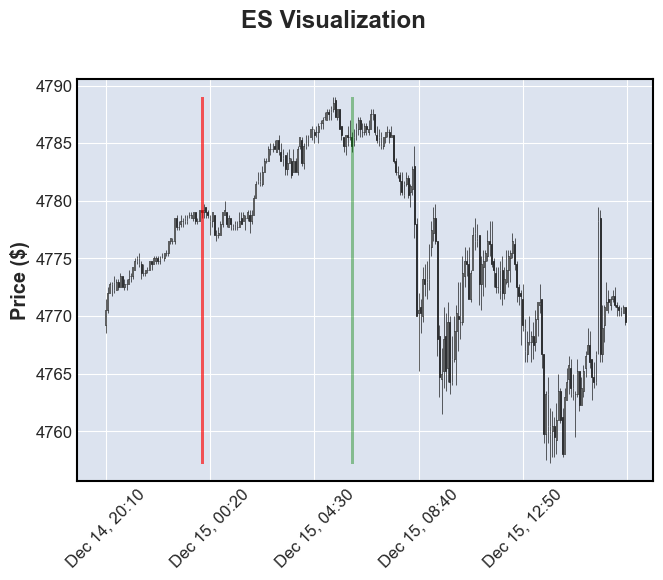

In [7]:
import mplfinance as fplt


def visualize_chart(ES, tail_number=50, horizontal_lines=[], add_special_times=True):
    
    df= ES.copy()
    
    df['Date'] = pd.to_datetime(df['DateTime'])  # Ensure 'DateTime' is a datetime object
    df.set_index("Date", inplace=True)
    df = df.tail(tail_number)
    
    # Prepare vertical lines for midnight, 6:00 AM, and 7:30 AM
    vlines = []
    if add_special_times:
        # Find the dates in the index for midnight
        midnight_dates = [dt.strftime('%Y-%m-%d %r') for dt in df.index if dt.time() == pd.to_datetime("00:00").time()]
        # Find the dates in the index for 6:00 AM and 7:30 AM
        am_times = [dt.strftime('%Y-%m-%d %r') for dt in df.index if dt.time() in [pd.to_datetime("00:00").time(), pd.to_datetime("06:00").time()]]

        # Combine the dates for vertical lines
        combined_times = midnight_dates + am_times
        colors = []

        for time in combined_times:
            if '12:00:00 AM' in time:
                colors.append('red')
            else:
                colors.append('green')
        
        if combined_times:
            vlines = {
                'vlines': combined_times,
                'colors': colors,
                'linewidths': 2,
                'alpha': 0.4
            }

    fplt.plot(
        df,
        warn_too_much_data=5000,   
        type='candle',
        title='ES Visualization',
        hlines=horizontal_lines,
        vlines=vlines,  # Vertical lines for special times
        ylabel='Price ($)'
    )

    # Display the plot
    fplt.show()

#Example usage:
visualize_chart(ES_5min_2  , 250)

#### Function: ES_add_pivot_low
The `ES_add_pivot_low` function is designed to identify pivot lows in a DataFrame `ES` that represents stock market data. This function creates a new column 'PivotLow' to mark the pivot lows.

#### Function: ES_add_pivot_high
The `ES_add_pivot_high` function is used to identify pivot highs in the DataFrame `ES`. It utilizes the `ES_add_pivot_low` function after manipulating the 'High' and 'Low' columns.


In [8]:
def ES_add_pivot_low(ES):
    ES['PivotLow'] = pd.NaT
    
    # ^ _ ^
    indices = ES[(ES['Low'].shift(1) > ES['Low']) & (ES['Low'].shift(-1) > ES['Low'])].index
    ES.loc[indices, 'PivotLow'] = ES.loc[indices, 'Low']
    
    # ^ means larger than the bottom, . means the bottom
    # ^ . _ . ^
    requirement2 = (ES['Low'].shift(1) >= ES['Low']) & (ES['Low'].shift(-1) >= ES['Low']) & (ES['Low'].shift(-2) > ES['Low']) & (ES['Low'].shift(2) > ES['Low'])
    indices2 = ES[requirement2].index
    ES.loc[indices2, 'PivotLow'] = ES.loc[indices2, 'Low']
    
    # ^ . _ ^
    requirement3 = (ES['Low'].shift(1) >= ES['Low']) & (ES['Low'].shift(-1) > ES['Low']) & (ES['Low'].shift(2) > ES['Low']) 
    indices3 = ES[requirement3].index
    ES.loc[indices3, 'PivotLow'] = ES.loc[indices3, 'Low']

    # ^ _ . ^
#     requirement4 = (ES['Low'].shift(-1) >= ES['Low']) & (ES['Low'].shift(1) > ES['Low']) & (ES['Low'].shift(-2) > ES['Low']) 
#     indices4 = ES[requirement4].index
#     ES.loc[indices4, 'PivotLow'] = ES.loc[indices4, 'Low']
       
    #How do I test this??
    #print when i loop through later
    
    filtered_df = ES[~ES['PivotLow'].isnull()]
    return ES


def ES_add_pivot_high(ES):
    # Create a temporary DataFrame with reversed 'High' and 'Low' columns
    temp_ES = ES.copy()
    virtualMax = virtual_high(ES)
    temp_ES['Low'] = virtualMax - ES['High']
    temp_ES['High'] = virtualMax - ES['Low']

    # Apply the pivot low function to the temporary DataFrame
    temp_ES = ES_add_pivot_low(temp_ES)

    # The pivot lows in the temporary DataFrame are pivot highs in the original DataFrame
    ES['PivotHigh'] = virtualMax - temp_ES['PivotLow']

    return ES

#https://www.youtube.com/watch?v=6CLD8MA8QKA&ab_channel=CasperSMC
#Casper smc time based liquidity

### Imbalance function
Check if that bar contains a bullish imbalance

It's forward shifted by 1 because during backtesting, I want to prevent the entry from seeing the future. Because effectively you need the next bar to confirm the imbalance.

In [9]:
#Delayed version
#It is when in reeal world you find out the imbalance after next candle close 
def add_bull_imbalance(ES):
    # Create shifted series for comparison
    previous_high = ES['High'].shift(1)
    next_low = ES['Low'].shift(-1)

    # Apply conditions to determine Bull Imbalance
    ES['BullImbalance'] = ((next_low > previous_high) &
                           (ES['High'] > next_low) &
                           (ES['Low'] < previous_high))
    
    ES['BullImbalance'] = ES['BullImbalance'].shift(1) #to prevent future seeing

    return ES




### New codes to find ifvg, i havnt really tested it

In [10]:
def find_first_larger_close(row, df):
    # Find the index of the current row
    idx = row.name
    # Filter the DataFrame from the current index onwards
    future_df = df.loc[idx+1:]
    # Find rows where 'Close' is larger than 'BearImbalanceHigh' of the current row
    larger_close_rows = future_df[future_df['Close'] > row['BearImbalanceHigh']]
    # If such rows are found, return the 'DateTime' of the first such row
    if not larger_close_rows.empty:
        return larger_close_rows.iloc[0]['DateTime']
    # Return NaN if no such row is found
    return np.nan

def add_bear_imbalance_hindsight(ES):
    # Create shifted series for comparison
    previous_low = ES['Low'].shift(1)
    next_high = ES['High'].shift(-1)

    # Apply conditions to determine Bear Imbalance
    ES['BearImbalance_hindsight'] = ((previous_low > next_high) &
                                     (ES['High'] > previous_low) &
                                     (ES['Low'] < next_high))

    # Assign values conditionally based on BearImbalance_hindsight
    ES['BearImbalanceHigh'] = np.where(ES['BearImbalance_hindsight'], previous_low, np.nan)
    ES['BearImbalanceLow'] = np.where(ES['BearImbalance_hindsight'], next_high, np.nan)
    ES['BearImbalanceLength'] = np.where(ES['BearImbalance_hindsight'], previous_low - next_high, np.nan)

    # Using apply to find the first 'DateTime' where 'Close' is larger than 'BearImbalanceHigh'
    ES['Broke_BearImbaance'] = ES.apply(lambda row: find_first_larger_close(row, ES), axis=1)

    return ES


### Bullish imbalance and find when close down below

In [11]:
def find_first_lower_close(row, df):
    # Find the index of the current row
    idx = row.name
    # Filter the DataFrame from the current index onwards
    future_df = df.loc[idx+1:]
    # Find rows where 'Close' is lower than 'BullImbalanceLow' of the current row
    lower_close_rows = future_df[future_df['Close'] < row['BullImbalanceLow']]
    
    
    
    # If such rows are found, return the 'DateTime' of the first such row
    if not lower_close_rows.empty:
        return lower_close_rows.iloc[0]['DateTime']
    # Return NaN if no such row is found
    return np.nan

def find_lowest_since_then(row, df):
    # Find the index of the current row
    idx = row.name
    # Filter the DataFrame from the current index onwards
    future_df = df.loc[idx+1:]
    
    
    if len(future_df) == 0 :
        return np.nan

    lowest_since = future_df['Low'].min()
    
    return lowest_since

def add_bull_imbalance_hindsight(ES):
    # Create shifted series for comparison
    previous_high = ES['High'].shift(1)
    next_low = ES['Low'].shift(-1)

    # Apply conditions to determine Bull Imbalance
    ES['BullImbalance_hindsight'] = ((next_low > previous_high) &
                                     (ES['High'] > next_low) &
                                     (ES['Low'] < previous_high))

    # Assign values conditionally based on BullImbalance_hindsight
    ES['BullImbalanceHigh'] = np.where(ES['BullImbalance_hindsight'], next_low, np.nan)
    ES['BullImbalanceLow'] = np.where(ES['BullImbalance_hindsight'], previous_high, np.nan)
    #ES['BullImbalanceLength'] = np.where(ES['BullImbalance_hindsight'], next_low - previous_high, np.nan)

    # Using apply to find the first 'DateTime' where 'Close' is lower than 'BullImbalanceLow'
    #ES['Broke_BullImbalance'] = ES.apply(lambda row: find_first_lower_close(row, ES), axis=1)
    #ES['Lowest_since_BullImbalance'] = ES.apply(lambda row: find_lowest_since_then(row, ES), axis=1)

    return ES

# Assuming ES is your DataFrame
# ES = add_bull_imbalance_hindsight(ES)


### Function: find_lowest_pivot_low_between_times
This function finds the lowest pivot low in the stock data between two specified times.

### Function: find_lowest_low_between_times
This function identifies the lowest 'Low' value in the stock data between two specified times.

### Function: find_first_low_below_value
This function locates the first instance where the 'Low' value falls below a specified value between two specified times.

In [12]:
#https://www.youtube.com/watch?v=6CLD8MA8QKA&ab_channel=CasperSMC
#Casper smc time based liquidity

def find_lowest_pivot_low_between_times(ES, start_time, end_time):
    """
    Function to find the lowest pivot low between two specified times.
    
    :param ES: DataFrame with stock data including 'PivotLow' and 'DateTime' columns.
    :param start_time: The start time for the period to search for the pivot low.
    :param end_time: The end time for the period to search for the pivot low.
    :return: The lowest 'PivotLow' value between the specified times.
    """

    # Filter the DataFrame for the specified time range
    time_filtered_ES = ES[(ES['DateTime'] >= start_time) & (ES['DateTime'] < end_time)]
    #print(time_filtered_ES)

    # Find the lowest 'PivotLow' in the filtered DataFrame
    lowest_pivot_low = -1
    lowest_pivot_low = time_filtered_ES['PivotLow'].min()
    
    
    #print(time_filtered_ES.head(100))

    return lowest_pivot_low



def find_lowest_low_between_times(ES, start_time, end_time):
    """
    Function to find the lowest 'Low' value between two specified times.

    :param ES: DataFrame with stock data including 'Low' and 'DateTime' columns.
    :param start_time: The start time for the period to search for the lowest 'Low'.
    :param end_time: The end time for the period to search for the lowest 'Low'.
    :return: The lowest 'Low' value between the specified times.
    """

    # Filter the DataFrame for the specified time range
    time_filtered_ES = ES[(ES['DateTime'] >= start_time) & (ES['DateTime'] < end_time)]

    # Find the lowest 'Low' in the filtered DataFrame
    lowest_low = time_filtered_ES['Low'].min()

    return lowest_low



def find_first_low_below_value(ES, start_time, end_time, value):
    """
    Function to find the first instance where 'Low' is below a specified value 
    between two specified times.

    :param ES: DataFrame with stock data including 'Low' and 'DateTime' columns.
    :param start_time: The start time for the period to search.
    :param end_time: The end time for the period to search.
    :param value: The value to compare the 'Low' against.
    :return: The DateTime of the first candlestick where 'Low' is below the value, or -1 if none found.
    """

    # Filter the DataFrame for the specified time range
    time_filtered_ES = ES[(ES['DateTime'] >= start_time) & (ES['DateTime'] < end_time)]

    # Find the first instance where 'Low' is below the specified value
    low_below_value = time_filtered_ES[time_filtered_ES['Low'] < value]

    if not low_below_value.empty:
        return low_below_value.iloc[0]['DateTime']
    else:
        return -1


### Function : check_liquidity_breakdown_in_session
Using the functions above, check if a time based liquidity is broken during AM or PM session

In [13]:
def check_liquidity_breakdown_in_session(ES, liquidity_start_time, liquidity_end_time):
    """
    Check if liquidity is taken within the same trading session and provide additional information.

    :param ES: DataFrame containing stock market data.
    :param liquidity_start_time: The start time of the liquidity session.
    :param liquidity_end_time: The end time of the liquidity session.
    :return: A tuple containing a boolean indicating if the latest 'Close' is above the lowest pivot low,
             the lowest pivot low value, and a number indicating the session type (0, 1, or 2).
    """
    is_am_session = False
    is_pm_session = False
    close_above = False
    
    # Retrieve the last row and its DateTime from the DataFrame
    latest_data_row = ES.iloc[-1]
    latest_datetime = latest_data_row['DateTime']
    latest_close = latest_data_row['Close']
    
    
    if latest_datetime < liquidity_end_time:
        print("Liquidity not applicable.")
        return False, virtual_high(ES), 0
    
    lowest_pivot_in_session = virtual_high(ES)
    
    time_difference = liquidity_end_time - liquidity_start_time
    
    # Find the lowest pivot low between the start and end time of the liquidity session
    lowest_pivot_in_session = find_lowest_low_between_times(ES, liquidity_start_time, liquidity_end_time)
    #if time_difference < pd.Timedelta(hours=24):    
    #    lowest_pivot_in_session = find_lowest_pivot_low_between_times(ES, liquidity_start_time, liquidity_end_time)
    #else:
    #    lowest_pivot_in_session = find_lowest_low_between_times(ES, liquidity_start_time, liquidity_end_time)
    
    print("==================================================")
    # Find the first instance where a low below the lowest pivot in the session occurs after the end of the liquidity session
    first_breakdown_time = find_first_low_below_value(ES, liquidity_end_time, latest_datetime, lowest_pivot_in_session)
    print(f"Time-based Liq from: {liquidity_start_time}, to: {liquidity_end_time}")
    print(f"Lowest pivot at the liq zone: {lowest_pivot_in_session}, Time it breaks down through: {first_breakdown_time}")

    if first_breakdown_time != -1:
        # Find the row where 'DateTime' matches the first breakdown time
        breakdown_row = ES[ES['DateTime'] == first_breakdown_time]

        if not breakdown_row.empty:
            # Extract the AMsession and PMsession flags for the breakdown time
            is_am_session = breakdown_row['AMsession'].iloc[0]
            is_pm_session = breakdown_row['PMsession'].iloc[0]
            print(f"Is it taken in : AMsession: {is_am_session}, PMsession: {is_pm_session}")
            
            # Check if the latest 'Close' is above the lowest pivot low
            close_above = latest_close > lowest_pivot_in_session

    # Determine the session type
    session_type = 0
    if is_am_session:
        session_type = 1
    elif is_pm_session:
        session_type = 2

    return lowest_pivot_in_session, session_type , first_breakdown_time

# Example usage:
# close_above, lowest_pivot, session_type = check_liquidity_breakdown_in_session(ES, liquidity_start_time, liquidity_end_time)
# print(f"Close above pivot: {close_above}, Lowest pivot: {lowest_pivot}, Session type: {session_type}")



### Function: virtual_high
A virtual high used to flip the dataset up-side-down to simulate shorting the asset

In [14]:
def virtual_high(ES):
    maximum_high = max(ES['High'])
    #rounded_maximum_high = math.ceil(maximum_high / 1000) * 1000 + 3000
    rounded_maximum_high = 10000
    #Just use 10000 to make it less confusing... but i need to change it manually after SP500 hits 10000
    return rounded_maximum_high

### Function: get_liquidity_grabbed
Using 'check_liquidity_breakdown_in_session' to get all the taken liquidity and return two list objects

1. liq_taken_list The level of liq you have taken
2. liq_taken_time The time it breaks down

In [15]:
def get_liquidity_grabbed(ES):
    latest_data_row = ES.iloc[-1]
    latest_datetime = latest_data_row['DateTime']
    
    # Extract the date from the latest datetime
    latest_date = latest_datetime.date()
    
    print(f"Your time is now: {latest_datetime}")
    
    # Create DateTime variables for specific times on the same date
    datetime_0am = pd.Timestamp(year=latest_date.year, month=latest_date.month, day=latest_date.day, hour=0)
    datetime_6am = datetime_0am + pd.Timedelta(hours=6)
    datetime_730am = datetime_0am + pd.Timedelta(hours=7, minutes=30)
    datetime_9am = datetime_0am + pd.Timedelta(hours=9)
    datetime_1030am = datetime_0am + pd.Timedelta(hours=10, minutes=30)
    datetime_12pm = datetime_0am + pd.Timedelta(hours=12)  # 12:00 PM
    datetime_1pm = datetime_0am + pd.Timedelta(hours=13)  # 1:00 PM
    datetime_230pm = datetime_0am + pd.Timedelta(hours=14, minutes=30)  # 2:30 PM

    # Create a DateTime variable for 6 PM on the previous day
    datetime_6pm_previous_day = datetime_0am - pd.Timedelta(hours=6)

    # Additional DateTime variables
    # Previous day 0 AM
    previous_day_0am = datetime_0am - pd.Timedelta(days=1)

    # Previous week's Monday 0 AM
    days_until_previous_monday = (latest_datetime.weekday() + 1) % 7
    previous_week_monday_0am = datetime_0am - pd.Timedelta(days=days_until_previous_monday + 6)

    # Previous week's Saturday 0 AM
    previous_week_saturday_0am = previous_week_monday_0am + pd.Timedelta(days=5)

    if False: #Debugging purpose only
        # Printing the timepoints
        print(f"Latest DateTime: {latest_datetime}")
        print(f"Today 0 AM: {datetime_0am}")
        print(f"Today 6 AM: {datetime_6am}")
        print(f"Today 7:30 AM: {datetime_730am}")
        print(f"Today 9 AM: {datetime_9am}")
        print(f"Today 10:30 AM: {datetime_1030am}")
        print(f"Previous Day 6 PM: {datetime_6pm_previous_day}")
        print(f"Previous Day 0 AM: {previous_day_0am}")
        print(f"Previous Week's Monday 0 AM: {previous_week_monday_0am}")
        print(f"Previous Week's Saturday 0 AM: {previous_week_saturday_0am}")
     
    
    # Define the time intervals
    time_intervals = [
        (previous_day_0am, datetime_0am),
        (previous_week_monday_0am , previous_week_saturday_0am )
    ]
    
    am_intervals = [
        (datetime_0am, datetime_6am),
        (datetime_6am, datetime_730am),
        (datetime_730am, datetime_9am),
        (datetime_9am, datetime_1030am)
    ]
    
    pm_intervals = [
        (datetime_730am , datetime_12pm),
        (datetime_12pm, datetime_1pm),
        (datetime_1pm, datetime_230pm)
    ]

    liq_taken_list = []
    liq_taken_time = []

    # Determine the current session type
    current_session_type = 0
    if ES['AMsession'].iloc[-1]:
        current_session_type = 1
        time_intervals = time_intervals + am_intervals
        
    elif ES['PMsession'].iloc[-1]:
        current_session_type = 2
        time_intervals = time_intervals + pm_intervals

    # Iterate through each time interval and perform the check
    for start_time, end_time in time_intervals:
        lowp, sstype,first_breakdown_time = check_liquidity_breakdown_in_session(ES, start_time, end_time)
        #print(lowp, sstype , first_breakdown_time)

        # Append to list if conditions are met
        if (sstype == current_session_type) and (first_breakdown_time.date() == latest_date):
            liq_taken_list.append(lowp)
            liq_taken_time.append(first_breakdown_time)
    print("=====================")
    print("Liquidity List")
    print(liq_taken_list)
    print("Time List")
    print(liq_taken_time)
    print("=====================")
    
    return liq_taken_list , liq_taken_time
    
        
    #I just need to return -1 or lowest liq taken and above

# Example usage:
# print_liquidity_timepoints(ES)


def rearrange_liquidity_data(liq_taken_list, liq_taken_time):
    """
    Rearrange the liquidity taken data in ascending order of time and keep only the minimum 
    value for duplicate times.

    :param liq_taken_list: List of liquidity taken points.
    :param liq_taken_time: List of times corresponding to the liquidity taken points.
    :return: Tuple of rearranged and filtered liquidity taken list and time list.
    """
    
    if len(liq_taken_list) == 0 or len(liq_taken_time) == 0:
        return [],[]
    
    # Combine the lists into a single list of tuples and sort them
    combined_list = sorted(zip(liq_taken_time, liq_taken_list))

    # Filter to keep only the minimum value for each unique time
    filtered_combined_list = {}
    for time, value in combined_list:
        if time not in filtered_combined_list or value < filtered_combined_list[time]:
            filtered_combined_list[time] = value

    # Unzip the filtered combined list back into two separate lists
    sorted_liq_taken_time, sorted_liq_taken_list = zip(*filtered_combined_list.items())

    return sorted_liq_taken_list, sorted_liq_taken_time
# Example usage:
# liq_taken_list, liq_taken_time = get_liquidity_grabbed(ES)
# sorted_liq_taken_list, sorted_liq_taken_time = rearrange_liquidity_data(liq_taken_list, liq_taken_time)
# print(sorted_liq_taken_list)
# print(sorted_liq_taken_time)


### create_entry_record
Create an empty table

In [16]:
def create_entry_record():
    """
    Creates and returns an empty DataFrame with specific columns.

    :return: Empty DataFrame with columns 'DateTime', 'StopLoss', 'State_BOS', 'State_IMB', 'State_Disp'.
    """
    columns = ['DateTime', 'StopLoss', 'State_BOS', 'State_IMB', 'State_Disp' , 'State_BO_IMB' ,'StopLoss_dt' 
               , 'TB_liq']
    empty_df = pd.DataFrame(columns=columns)
    return empty_df


def find_smallest_larger_than_or_min(numbers, target):
    """
    Finds the smallest number in the list that is larger than the target number.
    If no such number exists, returns the minimum number in the list.

    :param numbers: List of numbers.
    :param target: The target number.
    :return: The smallest number in the list that is larger than the target, or
             the minimum number in the list if no such number exists.
    """
    # Filter the list to find numbers greater than the target
    larger_than_target = [num for num in numbers if num > target]

    # Check if there are any numbers larger than the target
    if larger_than_target:
        # Return the smallest number from those larger than the target
        return min(larger_than_target)
    
    # Return the minimum number from the entire list if no number is larger than the target
    return min(numbers)

# Example usage
#numbers = [1, 4, 7, 9, 12]
#target = 5
#result = find_smallest_larger_than_or_min(numbers, target)
#print(f"The smallest number larger than {target} or the minimum of the list is: {result}")


### Find all the entries you can find in a date

In [30]:
def find_entry(ES, liquidity_taken_list, liq_taken_time):

    df = create_entry_record()
    
    if len(liquidity_taken_list) == 0 or len(liq_taken_time) == 0:
        return df

    
    
    latest_data_row = ES.iloc[-1]
    latest_datetime = latest_data_row['DateTime']
    most_recent_date = latest_datetime.date()

    first_liq_time = liq_taken_time[0]
    first_index = ES[ES['DateTime'] == first_liq_time].index[0]
    end_index = ES[ES['DateTime'] == latest_datetime].index[0]

    record_low = virtual_high(ES)
    record_low_dt = first_liq_time

    # Initialize state variables
    state = {
        "bos_detected": False,
        "imb_detected": False,
        "allowed_trade": False ,
        "displacement": False ,
        "bo_imb_detected" : False
    }

    def reset_variables(state):
        state["bos_detected"] = False
        state["imb_detected"] = False
        state["allowed_trade"] = False
        state["displacement"] = False
        state["bo_imb_detected"] = False
        #State_BO_IMB
        
    def add_to_df(df, state , new_dt , new_SL , disp_req , record_low_dt):
    
        new_entry = pd.DataFrame({
        'DateTime': [new_dt],
        'StopLoss': [new_SL],
        'DispReached': [disp_req],
        'State_BOS': [state["bos_detected"]],
        'State_IMB': [state["imb_detected"]],
        'State_Disp': [state["displacement"]],
        'State_BO_IMB' :  [state["bo_imb_detected"]],
        'StopLoss_dt' : [record_low_dt],
        'TB_liq' : find_smallest_larger_than_or_min(liquidity_taken_list ,new_SL )
        })
        
        return pd.concat([df, new_entry], ignore_index=True)
        
        
    #print(ES)    
        
    for index in range(first_index, end_index + 1):
        newest_low = ES.iloc[index]['Low']
        newest_high = ES.iloc[index]['High']
        newest_dt = ES.iloc[index]['DateTime']
        newest_imb = ES.iloc[index]['BullImbalance']
        newest_close = ES.iloc[index]['Close']

        #newest_TP = record_low + 0.9* distance_from_TP
        newest_TP = find_TP(ES , newest_dt , record_low)
        newest_disp_requirement = record_low + 0.5* (newest_TP - record_low ) #hardcode

        if newest_low < record_low:
            record_low = newest_low
            record_low_dt = newest_dt
            reset_variables(state)
            state["allowed_trade"] = True
            #print("reset")

        if check_BOS(ES, newest_dt):
            state["bos_detected"] = True

        if newest_imb:
            state["imb_detected"] = True
            
        if newest_high >= newest_disp_requirement:
            state["displacement"] = True
            
        if check_BO_IMB(ES, newest_dt, record_low):
            state["bo_imb_detected"] = True
            
            
        trigger_condition =  state["allowed_trade"] and state["displacement"] and (state["imb_detected"] 
                             or state["bo_imb_detected"] )
        #or state["bos_detected"]
        # Additional logic for ifvg can be included here

        #print(newest_dt, state["bos_detected"], state["imb_detected"] , newest_lastsession_high , state["displacement"])
        #print(newest_TP)
        if trigger_condition:
            df = add_to_df(df, state ,newest_dt , record_low , newest_disp_requirement , record_low_dt )
            print("tp", newest_TP)
            reset_variables(state)
            #print("triggr reset")
            #date time
            #SL
            #which state is 1
        
    #print(df)
        
    return df

# Example usage:
# find_entry(ES, liquidity_taken_list, liq_taken_time)


### find_max_high_since_3AM
Literally finding the maximum point after some time

### find TP
Literally the function used to find the TP point

In [18]:
def find_max_high_since_3AM(ES, specific_datetime , start_hour = 3 , start_minute = 0):
    """
    Find the maximum 'High' value in the DataFrame ES from 3 AM on the same date up to the specific row.

    :param ES: DataFrame containing stock market data.
    :param specific_datetime: The specific datetime to consider.
    :return: Maximum 'High' value since 3 AM of the same date.
    """
    # Extract the date from the specific datetime
    date_of_interest = specific_datetime.date()

    # Find 3 AM of the specific date
    date_3AM = pd.Timestamp(date_of_interest, hour=start_hour , minute = start_minute )

    # Filter data from 3 AM to the specific datetime
    filtered_data = ES[(ES['DateTime'] >= date_3AM) & (ES['DateTime'] <= specific_datetime)]

    # Find the maximum 'High' in the filtered data
    max_high = filtered_data['High'].max()

    return max_high


def find_TP(ES , dt , record_low):
    
    matching_row = ES[ES['DateTime'] == dt]
    
    row = matching_row.iloc[0]
    
    newest_lastsession_high = 0
    if row['AMsession']:
        newest_lastsession_high = find_max_high_since_3AM(ES ,dt )
    elif row['PMsession']:
        newest_lastsession_high = find_max_high_since_3AM(ES ,dt  , start_hour = 7 , start_minute = 30 )
    else:
        newest_lastsession_high = find_max_high_since_3AM(ES ,dt )
        
        
    distance_from_TP = newest_lastsession_high - record_low
    newest_TP = record_low + 0.9 * distance_from_TP #hardcode
    
    return newest_TP

### BOS detection
Just input the dataframe , and the time you want to check

Sample checked okay

In [19]:
def check_BOS(ES, dt):
    MAX_BAR_CHECK = 100
    # Find the index of the row that matches the datetime 'dt'
    target_index = ES[ES['DateTime'] == dt].index
    target_close = float(ES.iloc[target_index]['Close'])
    
    #print(target_index)
    # Check if the target index is found
    if target_index.empty:
        #print("Datetime not found in DataFrame.")
        return False

    # Retrieve the actual index
    target_index = target_index[0]
    record_high_close = 0 
    record_high_pivot = 0

    # Loop to print 'PivotHigh' for the specified number of bars before 'dt'
    for i in range(MAX_BAR_CHECK):
        # Calculate the index to check
        check_index = target_index - i -1
        
        check_close = ES.iloc[check_index]['Close']
        if check_close > record_high_close :
            record_high_close = check_close
            
        pivot_high = ES.iloc[check_index]['PivotHigh']
        if pd.notna(pivot_high):
            if pivot_high > record_high_pivot:
                record_high_pivot = pivot_high
            
            #print(ES.iloc[check_index]['DateTime'])
            #print("pivot high" , ES.iloc[check_index]['PivotHigh'])
            #print("record high" , record_high_close)
            #print("target close" , target_close)
            
            
            if (record_high_close < record_high_pivot) and (target_close > record_high_pivot):
                #print("BOS detected")
                return True
            
            
            if pivot_high >= target_close:
                break
                
            if record_high_close > target_close:
                break
                
        else:
            continue
        
        
        # Ensure the index is within the bounds of the DataFrame
        if check_index >= 0:
            #print(ES.iloc[check_index]['DateTime'])
            #print(ES.iloc[check_index]['PivotHigh'])
            #print(record_high_close)
            _a = 0 
        else:
            break  # Exit the loop if the index is out of bounds

    return False

# Example usage:
# check_BOS(ES, some_datetime)


### Break of imbalance detection

In [41]:
def check_BO_IMB(ES, dt , stopLoss):
    MAX_BAR_CHECK = 100
    # Find the index of the row that matches the datetime 'dt'
    target_index = ES[ES['DateTime'] == dt].index
    target_close = float(ES.iloc[target_index]['Close'])
    higher_allowance = float(ES.iloc[target_index]['005_range'] * 4)
    min_imbalance_size = float(ES.iloc[target_index]['005_range'] * 1)
    
    #print(target_index)
    # Check if the target index is found
    if target_index.empty:
        #print("Datetime not found in DataFrame.")
        return False

    # Retrieve the actual index
    target_index = target_index[0]
    record_high_close = 0 
    record_high_imb = 0

    # Loop to print 'PivotHigh' for the specified number of bars before 'dt'
    for i in range(MAX_BAR_CHECK):
        # Calculate the index to check
        check_index = target_index - i -1
        
        check_close = ES.iloc[check_index]['Close']
        if check_close > record_high_close :
            record_high_close = check_close
            
        imb_high = ES.iloc[check_index]['BearImbalanceHigh']
        imb_low = ES.iloc[check_index]['BearImbalanceLow']
        imb_size = imb_high - imb_low
        if pd.notna(imb_high):
            if imb_high > record_high_imb:
                record_high_imb = imb_high
            
            #print(ES.iloc[check_index]['DateTime'])
            #print("pivot high" , ES.iloc[check_index]['PivotHigh'])
            #print("record high" , record_high_close)
            #print("target close" , target_close)
            
            
            if (target_close > imb_high) and ( stopLoss < imb_low ) and (imb_size > min_imbalance_size):
                #print("IMB detected")
                #print(ES.iloc[check_index]['DateTime'] , "at" ,dt )
                #print(imb_high)
                #print(imb_low)
                return True
            
            
            if imb_high >= target_close:
                break
            
            if record_high_close > higher_allowance:
                break
                
                
        else:
            continue
        
        
        # Ensure the index is within the bounds of the DataFrame
        if check_index >= 0:
            #print(ES.iloc[check_index]['DateTime'])
            #print(ES.iloc[check_index]['PivotHigh'])
            #print(record_high_close)
            _a = 0 
        else:
            break  # Exit the loop if the index is out of bounds

    return False

# Example usage:
# check_BOS(ES, some_datetime)

### Getting a standard sizing on some operations, like inverting a FVG

In [21]:
def add_diff_mult_005(ES):

    # Calculate rolling max of 'High' over the past 100 bars
    rolling_high = ES['High'].rolling(window=100).max()

    # Calculate rolling min of 'Low' over the past 100 bars
    rolling_low = ES['Low'].rolling(window=100).min()

    # Calculate the difference, multiply by 0.05, and assign to a new column
    ES['005_range'] = (rolling_high - rolling_low) * 0.05

    return ES

### Post-processing after getting a trade, adding more feature like the 830 and discount comparison.

In [22]:
def get_low_high_since_3AM(long_df, es_df):
    """
    Adds new columns to long_entry_list_w_gain DataFrame with the minimum 'Low' value 
    and maximum 'High' value since 3 AM of the same day for each 'DateTime'.

    :param long_df: DataFrame with long entry data.
    :param es_df: DataFrame with stock data history (ES_5min).
    """
    # Ensure 'DateTime' is in datetime format
    long_df['DateTime'] = pd.to_datetime(long_df['DateTime'])
    es_df['DateTime'] = pd.to_datetime(es_df['DateTime'])

    # Function to find minimum 'Low' and maximum 'High' since 3 AM of the same day
    def min_low_max_high_since_3AM(row_datetime):
        same_day_3AM = row_datetime.replace(hour=3, minute=0, second=0, microsecond=0)
        # Filter ES_5min for rows from 3 AM up to the row's DateTime
        filtered = es_df[(es_df['DateTime'] >= same_day_3AM) & (es_df['DateTime'] <= row_datetime)]
        if not filtered.empty:
            return filtered['Low'].min(), filtered['High'].max()
        return None, None

    # Apply the function to each row in long_entry_list_w_gain to get the new column values
    results = long_df['DateTime'].apply(lambda x: pd.Series(min_low_max_high_since_3AM(x), index=['Low_since_3AM', 'High_since_3AM']))
    long_df = pd.concat([long_df, results], axis=1)
    
    
    return long_df


def add_dp_line(long_df):
    """
    Adds a column 'DP_Line' to the DataFrame, which is the average of 'Low_since_3AM' and 'High_since_3AM',
    and then drops the 'Low_since_3AM' and 'High_since_3AM' columns.

    :param long_df: DataFrame that includes 'Low_since_3AM' and 'High_since_3AM' columns.
    """
    # Calculate the average (middle point) between 'Low_since_3AM' and 'High_since_3AM'
    long_df['DP_Line'] = (long_df['Low_since_3AM'] + long_df['High_since_3AM']) / 2

    # Add a column 'Discount' to indicate if 'DispReached' is less than 'DP_Line'
    long_df['Discount'] = (long_df['StopLoss']+(long_df['DispReached']-long_df['StopLoss'])*0.67) < long_df['DP_Line']

    # Drop the 'Low_since_3AM' and 'High_since_3AM' columns
    long_df.drop(['Low_since_3AM', 'High_since_3AM' , 'DP_Line'], axis=1, inplace=True)

    return long_df


def add_rebounce_columns(long_entry_list, es_df):
    """
    Adds columns to indicate if there was a rebound from the open prices at 8:30 AM and 00:00 (midnight),
    and then removes the open price columns.

    Parameters:
    - long_entry_list: DataFrame with 'DateTime', 'StopLoss', and 'DispReached' columns.
    - es_df: DataFrame containing 'DateTime' and 'Open' prices for each timestamp.

    Returns:
    - Modified long_entry_list DataFrame with 'Rebounce_From_830' and 'Rebounce_From_0000' columns added.
    """
    
    def get_open_at_time(date, es_df, hour, minute):
        """Helper function to fetch open price at a specified hour and minute for a given date."""
        datetime_target = pd.Timestamp(date.date()).replace(hour=hour, minute=minute)
        row = es_df[es_df['DateTime'] == datetime_target]
        return row.iloc[0]['Open'] if not row.empty else None
    
    # Fetch open prices
    long_entry_list['Open_at_830'] = long_entry_list['DateTime'].apply(lambda x: get_open_at_time(x, es_df, 8, 30))
    long_entry_list['Open_at_0000'] = long_entry_list['DateTime'].apply(lambda x: get_open_at_time(x, es_df, 0, 0))
    
    # Determine rebounds
    long_entry_list['Rebounce_From_830'] = long_entry_list.apply(lambda row: 
                                                                  row['StopLoss'] < row['Open_at_830'] and 
                                                                  row['DispReached'] > row['Open_at_830'], 
                                                                  axis=1)
    
    long_entry_list['Rebounce_From_0000'] = long_entry_list.apply(lambda row: 
                                                                  row['StopLoss'] < row['Open_at_0000'] and 
                                                                  row['DispReached'] > row['Open_at_0000'], 
                                                                  axis=1)
    
    # Remove the open price columns
    long_entry_list.drop(['Open_at_830', 'Open_at_0000'], axis=1, inplace=True)
    
    return long_entry_list


### Analyze the ES dataframe
0. Filtering the date time, 8 days ago to current time,
checking: done for verifying the last row is the time you input
1. Get the AP PM session from Tuesday to Friday by loading get_AMPM_sessions
2. It is the main function you use to analyze a session

Your time is now: 2023-10-31 11:30:00
Time-based Liq from: 2023-10-30 00:00:00, to: 2023-10-31 00:00:00
Lowest pivot at the liq zone: 4149.0, Time it breaks down through: -1
Time-based Liq from: 2023-10-23 00:00:00, to: 2023-10-28 00:00:00
Lowest pivot at the liq zone: 4122.25, Time it breaks down through: -1
Time-based Liq from: 2023-10-31 00:00:00, to: 2023-10-31 06:00:00
Lowest pivot at the liq zone: 4166.75, Time it breaks down through: -1
Time-based Liq from: 2023-10-31 06:00:00, to: 2023-10-31 07:30:00
Lowest pivot at the liq zone: 4192.5, Time it breaks down through: 2023-10-31 08:35:00
Is it taken in : AMsession: True, PMsession: False
Time-based Liq from: 2023-10-31 07:30:00, to: 2023-10-31 09:00:00
Lowest pivot at the liq zone: 4187.5, Time it breaks down through: 2023-10-31 09:20:00
Is it taken in : AMsession: True, PMsession: False
Time-based Liq from: 2023-10-31 09:00:00, to: 2023-10-31 10:30:00
Lowest pivot at the liq zone: 4171.75, Time it breaks down through: -1
Liquidi

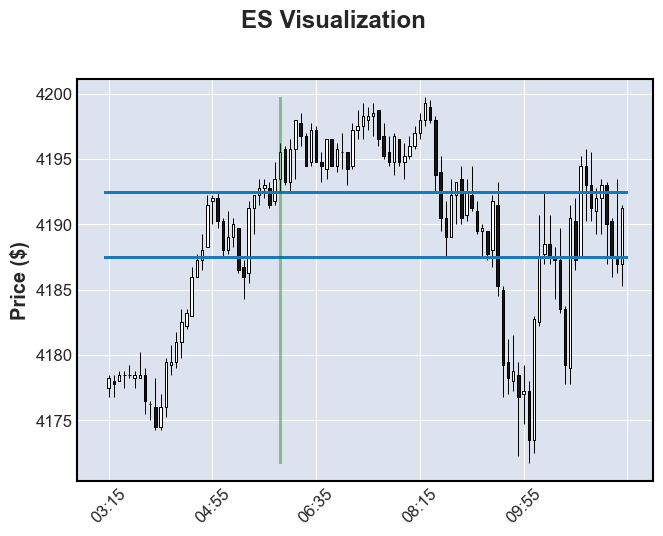

tp 4196.95
             DateTime  StopLoss State_BOS State_IMB State_Disp State_BO_IMB  \
0 2023-10-31 10:10:00   4171.75      True      True       True         True   

          StopLoss_dt  TB_liq  DispReached  Discount  Rebounce_From_830  \
0 2023-10-31 10:00:00  4187.5      4184.35      True              False   

   Rebounce_From_0000  
0               False  


In [43]:
def analyze_ES_from_time(ES , dt_text , visual = True , bars_to_shows = 100):
    start_date = pd.to_datetime(dt_text)
    end_date = start_date - pd.DateOffset(days=25)
    
    ES = ES[(ES['DateTime'] >= end_date) & (ES['DateTime'] <= start_date)].reset_index(drop=True)
    #print(ES)
    
    
    ES = get_AMPM_sessions(ES)
    ES= ES_add_pivot_low(ES)
    ES= ES_add_pivot_high(ES)
    ES = add_bull_imbalance(ES)
    ES = add_bear_imbalance_hindsight(ES)
    ES = add_diff_mult_005(ES)
    
    #print(ES)
   
    latest_data_row = ES.iloc[-1]
    latest_datetime = latest_data_row['DateTime']
    
    
    
    if not (latest_data_row['AMsession'] or latest_data_row['PMsession']):
        print("Invalid Session")
        return -1
    
    # Check if previous day's 7:30 AM exists in the DataFrame
    previous_day_730am = pd.Timestamp(latest_datetime.date() - pd.Timedelta(days=1), hour=7, minute=30)
    previous_day_1330pm = pd.Timestamp(latest_datetime.date() - pd.Timedelta(days=1), hour=13, minute=30)
    if not any(ES['DateTime'] == previous_day_730am):
        print("Yesterday was not a full day.")
        return -1
    if not any(ES['DateTime'] == previous_day_1330pm):
        print("Yesterday was not a full day.")
        return -1
    
    
    liquidity_taken_list ,liq_taken_time  = get_liquidity_grabbed(ES)
    
    liquidity_taken_list_r , liq_taken_time_r = rearrange_liquidity_data(liquidity_taken_list , liq_taken_time)
    if visual:
        print(liquidity_taken_list_r , liq_taken_time_r)
    
    #print(liquidity_taken_list ,liq_taken_time )
    
    #402 is a day starting 930
    if visual:
        visualize_chart(ES,tail_number = bars_to_shows , horizontal_lines =liquidity_taken_list)
  
    entry_result = find_entry(ES , liquidity_taken_list_r , liq_taken_time_r )
    
    #test_object = pd.to_datetime("2023-12-1 3:00:00")
    #testresult = check_BOS(ES , test_object)
    #print("BOS " ,testresult )
    if not entry_result.empty:
        entry_result = get_low_high_since_3AM(entry_result, ES)
        entry_result = add_dp_line(entry_result)
        entry_result = add_rebounce_columns(entry_result ,ES )
    
    
    return entry_result , ES
    
    
entry_list , es_0  = analyze_ES_from_time(ES_5min , "2023-10-31 11:30:00" )
print(entry_list)

#28/6/2023 is a good example
#29/6/2023 is a good example
#28/9/2023
#7/7/2023
#21/7/2023
#18/8/2023
#1/12/2023
#25/8/2023 
#16/11/2023
#27/11/2023
#31/10/2023
#30/10/2023 (Mon)
#6/6/2023 PM session

### To easily get the full analysis of the extracted buying opportunity

In [28]:
def extract_1130_1530(ES):
    """
    Extracts all dates with specific times (11:30 AM and 3:30 PM) from the DataFrame and converts them to text.

    :param ES: DataFrame with a 'DateTime' column.
    :return: List of date and time strings for specific times.
    """
    # Define the specific times
    time_1130am = pd.to_datetime("11:30").time()
    time_1530pm = pd.to_datetime("15:30").time()

    # Filter DataFrame for rows where the time is either 11:30 AM or 3:30 PM
    filtered_dates = ES[(ES['DateTime'].dt.time == time_1130am) | (ES['DateTime'].dt.time == time_1530pm)]

    # Convert the DateTime column to text (string) format
    trading_times_text_list = filtered_dates['DateTime'].dt.strftime('%Y-%m-%d %H:%M:%S').tolist()

    return trading_times_text_list

def get_entry_list(ES):
    
    time_list = extract_1130_1530(ES)
    initial_df = create_entry_record()
    for t_text in time_list:
        analyzed_df = analyze_ES_from_time(ES , t_text , visual = False)
        if(type(analyzed_df) == int):
            continue;
        initial_df = pd.concat([initial_df, analyzed_df], ignore_index=True)
        
    
    return initial_df

### Running from a date time, giving it a stop loss, it will keep adjusting TP and find if it can buy in and lose or win

In [29]:
from datetime import timedelta
import pandas as pd

def get_trading_result(ES, target_datetime, stop_loss):
    """
    Prints the 'Low' of the candlestick at the target_datetime, finds the index of that row in ES,
    and prints the 'High' using the iloc index. Also calculates the trading end datetime by adding 75 minutes to the target datetime.

    :param ES: DataFrame containing stock market data.
    :param target_datetime: The specific datetime to consider.
    :param stop_loss: The stop loss value (not used in the current logic but included for completeness).
    """
    # Filter the DataFrame for the row matching the target_datetime
    target_row = ES[ES['DateTime'] == target_datetime]
    
    # Calculate end datetime by adding 75 minutes to the target datetime
    end_datetime = target_datetime + timedelta(minutes=45)

    # Get the index of the target row
    target_index = target_row.index[0]
    
    
    index = target_index + 1
    
    order_Entry = -1
    order_TP = -1
    order_SL = stop_loss
    
    
    while(True):
        
        newest_dt = ES.iloc[index]['DateTime']
        tp = find_TP(ES , newest_dt , stop_loss)
        entry_point = stop_loss + (tp - stop_loss)*1/3.1 #hardcode
        entry_point = round(entry_point, 1)
        newest_low = ES.iloc[index]['Low']
        print(ES.iloc[index]['DateTime'] )
        print("SL:" , stop_loss)
        print("TP: " , tp )
        print("Entry: " , entry_point)
        
        if newest_low <  entry_point:
            print("Entry!!")
            print(newest_low)
            print(entry_point)
            
            order_Entry = entry_point
            order_TP = tp
            
            break;
        
        
        day_end_time = pd.Timestamp(newest_dt.date()) + pd.Timedelta(hours=15, minutes=40)
        if newest_dt >= day_end_time or newest_dt >= end_datetime:
            return 0
        
        index +=1 
        
    while (True):
        
        newest_dt = ES.iloc[index]['DateTime']
        newest_low = ES.iloc[index]['Low']
        newest_high = ES.iloc[index]['High']
        
        if newest_low <= order_SL:
            return -1
        if newest_high > order_TP:
            return 2.1 #hardcode
        day_end_time = pd.Timestamp(newest_dt.date()) + pd.Timedelta(hours=16, minutes=0)
        if newest_dt >= day_end_time:
            gain = (ES.iloc[index]['Close'] - order_Entry)
            print(gain)
            bet_size = (order_Entry - stop_loss)
            print(bet_size)
            print("check whats wrong")
            print(ES.iloc[index]['Close'] , order_Entry ,stop_loss  )
            return gain/bet_size
        
        index+=1
            
        
def add_gain_row_by_row(df0 , ES):
    """
    Adds a new column 'Gain' to the DataFrame and assigns a random number to each row, one by one.
    """
    # Initialize the 'Gain' column with zeros or NaN
    df = df0.copy()
    df['Gain'] = np.nan
    
    for index, row in df.iterrows():
        # Assign a random number to the 'Gain' column for each row
        print(index)
        newest_dt = df.at[index, 'DateTime']
        newest_sl = df.at[index, 'StopLoss']
        gain = get_trading_result(ES, newest_dt, newest_sl)
        print(gain)
        print("=================================")
        df.at[index, 'Gain'] = round(gain, 2)  # Round to 2 decimal places for example
        
    return df
        
        


In [ ]:
long_entry_list = get_entry_list(ES_5min)
short_entry_list = get_entry_list(ES_5min_reversed)
long_entry_list_w_gain = add_gain_row_by_row(long_entry_list , ES_5min)
short_entry_list_w_gain = add_gain_row_by_row(short_entry_list , ES_5min_reversed)
#a
#a.to_csv('Trading_Triggered_Displacement_n_Imbalance_Long.csv', index=False)

In [ ]:
csv_filename = 'long_entry_list_w_gain_disp50_w_high_imb_only_45mintake_use_sectionLow.csv'
#long_entry_list_w_gain.to_csv(csv_filename, index=True)
long_entry_list_w_gain = pd.read_csv(csv_filename, index_col=0)

csv_filename = 'short_entry_list_w_gain_disp50_w_high_imb_only_45mintake_use_sectionLow.csv'
#short_entry_list_w_gain.to_csv(csv_filename, index=True)
short_entry_list_w_gain = pd.read_csv(csv_filename, index_col=0)

In [ ]:
long_entry_list_w_gain

In [ ]:
long_entry_list_w_gain.head(20)


In [ ]:
# import pandas as pd

# Assuming long_entry_list_w_gain is your DataFrame and it has a 'DateTime' column of datetime type
# If 'DateTime' is not already a datetime type, convert it first
long_entry_list_w_gain['DateTime'] = pd.to_datetime(long_entry_list_w_gain['DateTime'])

# Filter the DataFrame for rows where the year is 2022
filtered_df = long_entry_list_w_gain[long_entry_list_w_gain['DateTime'].dt.year == 2022]

# Now filtered_df will only contain rows where 'DateTime' is within the year 2022
filtered_df[filtered_df['Gain'] == 2.1]

In [ ]:
short_entry_list_w_gain[short_entry_list_w_gain['Gain'] != 0]

In [ ]:
def get_open_at_830(date, es_df):
    # Generate the datetime for 8:30 AM on the same date
    datetime_830 = pd.Timestamp(date.date()).replace(hour=8, minute=30)
    # Find the row in es_df that matches this datetime
    row = es_df[es_df['DateTime'] == datetime_830]
    if not row.empty:
        return row.iloc[0]['Open']
    return None

# Apply the function row-wise to 'a_w_gain' and create a new column with the results
long_entry_list_w_gain['Open_at_830'] = long_entry_list_w_gain['DateTime'].apply(lambda x: get_open_at_830(x, ES_5min))

print(a_w_gain)

In [ ]:
pd.set_option('display.max_rows', None)
filtered_a_w_gain
pd.set_option('display.max_rows', 20)

